### Imports

In [14]:
import os
import torch
import imageio
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIV_PINN_model_restart import StreamfunctionNetwork, HydroNetwork, WeakPINN

### Import data and make grids

In [22]:
data_path = '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/'

# FLUID DATA
mat_profile_1 = loadmat(data_path + 'stokes_flow_profile_1_restart_final.mat')
mat_profile_2 = loadmat(data_path + 'stokes_flow_profile_2_restart_final.mat')
# for key, value in mat_profile_1.items(): print(key)

frames = 10  # frames to load (if you don't want to load all of them)

# Get spacetime coordinates (x, y, t) and velocity components (u, v)
y, x, t, u1, v1 = mat_profile_1['x'], mat_profile_1['y'], np.linspace(0, len(mat_profile_1['x'])-1, len(mat_profile_1['x'])), \
    mat_profile_1['u'], mat_profile_1['v']

u1, v1 = torch.tensor(u1, dtype=torch.float, requires_grad=False), torch.tensor(v1, dtype=torch.float, requires_grad=False)
u1, v1, t = u1[...,:frames], v1[...,:frames], t[...,:frames]

u2, v2 = mat_profile_2['u'], mat_profile_2['v']

u2, v2 = torch.tensor(u2, dtype=torch.float, requires_grad=False), torch.tensor(v2, dtype=torch.float, requires_grad=False)
u2, v2 = u2[...,:frames], v2[...,:frames]
    
x_grid, y_grid, t_grid = torch.tensor(x[0][0][:, 0], dtype=torch.float, requires_grad=True), torch.tensor(y[0][0][0][:], dtype=torch.float, requires_grad=True), \
    torch.linspace(0, int(t[-1]), int(t[-1]+1), requires_grad=True)

# T, X, Y = torch.meshgrid( (t_grid, x_grid, y_grid) )

X, Y, Z, T = torch.meshgrid( (x_grid, x_grid, y_grid, t_grid) )

print(Y.shape, u1.shape)
print(torch.max(u1))

torch.Size([13, 13, 13, 10]) torch.Size([13, 13, 10])
tensor(0.8479)


### Visual Checks

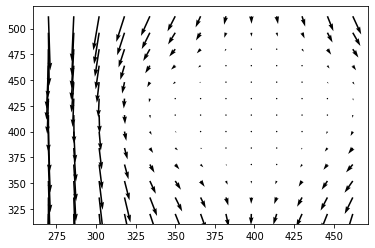

In [33]:
# Check the input flow field
fig, ax = plt.subplots()
# ax.quiver(X[0,...].detach().numpy(), Y[0,...].detach().numpy(), u[0,...], v[0,...])
ax.quiver(X[:,6,:,0].detach().numpy(), Z[:,6,:, 0].detach().numpy(), u1[...,0], v1[...,0])
plt.show()


/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/2604172907.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


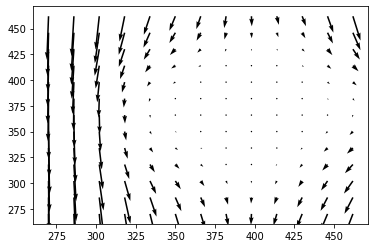

In [24]:
# Check the input flow field
# fig, ax = plt.subplots(figsize=(16,12))
# frame=4
# ax.quiver(X[..., 0, frame].detach().numpy(), Y[..., 0, frame].detach().numpy(), u1[...,frame], v1[...,frame])
# plt.show()

# Create a gif of the input flow field
for frame in range(frames):
    u_i, v_i = u1[...,frame], v1[...,frame]
    
    plt.close('all')
    plt.quiver(X[..., 0, frame].detach().numpy(), Y[..., 0, frame].detach().numpy(), u_i, v_i)
    plt.savefig(f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/input_images/input{frame}.png', dpi=300)

filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/input_images/input{frame}.png' for frame in range(frames)]
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/input.gif', images, fps=5)

In [5]:
MSE_losses = []
NSE_losses = []
wall_losses = []

### Make NN

In [18]:
X = torch.reshape( X, [-1,1] )
Y = torch.reshape( Y, [-1,1] )
Z = torch.reshape( Z, [-1,1])
T = torch.reshape( T, [-1,1] )

xs      = torch.cat( (X,Y,Z,T), dim=1 )
xs_uniform = xs.clone().detach()
true_data = (torch.tensor(u1, dtype=torch.float, requires_grad=False), torch.tensor(v1, dtype=torch.float, requires_grad=False), 
             torch.tensor(u2, dtype=torch.float, requires_grad=False), torch.tensor(v2, dtype=torch.float, requires_grad=False))
frame = 0

# Parameters
epochs=1
epoch=1

nu = 1.0
nu = torch.nn.Parameter(torch.tensor(nu, dtype=torch.float, requires_grad=True))

stream_model = StreamfunctionNetwork( L=16 )
hydro_model = HydroNetwork( stream_model )
pinn = WeakPINN( hydro_model, nu )

psi = stream_model.forward(xs)
f   = hydro_model.forward(xs)
err = pinn.forward(xs, true_data, (x_grid, x_grid, y_grid, t_grid), epoch, epochs)

criterion = nn.MSELoss()
optimizer = optim.Adam(hydro_model.parameters(), lr=0.0001)

loss_history = torch.zeros( (epochs) )

def save_network_output( hydro_model, out_name, grids ):
    # After training, you can use the trained model for predictions
    
    x_grid, y_grid, z_grid, t_grid = grids[0], grids[1], grids[2], grids[3]
    ns=( len(x_grid),len(y_grid),len(z_grid),len(t_grid) )

    f_final, NSE = hydro_model.forward(xs)  # contains [w, u, v, T, a]

    f_final = f_final.detach().numpy()
    x_grid  = x_grid.detach().numpy()
    y_grid  = y_grid.detach().numpy()
    z_grid  = z_grid.detach().numpy()

    f_final = np.reshape( f_final, [ns[0], ns[1], ns[2], ns[3], -1] )

    out_dict =  {"f": f_final, "x_grid": x_grid, "y_grid": y_grid, "z_grid": z_grid, "loss_history": loss_history }
    savemat(out_name, out_dict)

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/3055232906.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_data = (torch.tensor(u1, dtype=torch.float, requires_grad=False), torch.tensor(v1, dtype=torch.float, requires_grad=False),
/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/3055232906.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(u2, dtype=torch.float, requires_grad=False), torch.tensor(v2, dtype=torch.float, requires_grad=False))


### Run training loop

In [7]:
if os.path.exists('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart.pth'): 
    pinn.load_state_dict(torch.load('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart.pth'))
    pinn.eval()
epochs = 1
for epoch in range(epochs):
    # Forward pass
    NSE, u, v, w = pinn.forward(xs, true_data, (x_grid, x_grid, y_grid, t_grid), epoch, epochs)
    
    # (u,v,w) are defined at each point in the box of size [13,13,15] for each point in time
    
    def LOSS():
        # loss = criterion(NSE, torch.zeros_like(NSE)) + criterion(u[...,6,:], true_data[0]) + criterion(v[...,6,:], true_data[1]) + criterion(v[6,...].permute(1,0,2), true_data[3]) +\
        #     criterion(w[6,...].permute(1,0,2), true_data[2])
            
        loss = criterion(NSE, torch.zeros_like(NSE)) + criterion(u[...,6,:,:], true_data[0]) + criterion(w[...,6,:,:], true_data[1]) +\
               criterion(v[6,...], true_data[2]) + criterion(w[6,...], true_data[3])

        NSE_err = criterion(NSE, torch.zeros_like(NSE))
        
        MSE_err = torch.abs(u[...,6,:,:].flatten() - true_data[0].flatten()) + torch.abs(w[...,6,:,:].flatten() - true_data[1].flatten()) +\
            torch.abs(v[6,...].flatten() - true_data[2].flatten()) + torch.abs(w[6,...].flatten() - true_data[3].flatten())
            
        MSE_err = criterion(MSE_err, torch.zeros_like(MSE_err))
        
        NSE_losses.append(NSE_err.item())
        MSE_losses.append(MSE_err.item())
        
        return loss
    
    # Backward pass and optimization step
    optimizer.zero_grad()  # clear previous gradients
    loss = LOSS()
    loss.backward(retain_graph=True)   # compute gradients
    optimizer.step()  # update model parameters
    
    # Print the loss every few epochs
    if epoch % 2 == 0:
        print(f" Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        
# Save the model to reload for the next frame
#torch.save(pinn.state_dict(), '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart.pth')

# Make gif
filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/output_images/reconstruction_revised{i}.png' for i in range(len(t_grid))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/reconstruction_revised.gif', images, fps=5)

 Epoch 0/400, Loss: 8.334091186523438
 Epoch 2/400, Loss: 8.323142051696777
 Epoch 4/400, Loss: 8.31601619720459
 Epoch 6/400, Loss: 8.308984756469727
 Epoch 8/400, Loss: 8.299644470214844
 Epoch 10/400, Loss: 8.286600112915039
 Epoch 12/400, Loss: 8.272441864013672
 Epoch 14/400, Loss: 8.25351333618164
 Epoch 16/400, Loss: 8.236451148986816
 Epoch 18/400, Loss: 8.218634605407715
 Epoch 20/400, Loss: 8.19559097290039
 Epoch 22/400, Loss: 8.171113014221191
 Epoch 24/400, Loss: 8.144905090332031
 Epoch 26/400, Loss: 8.114563941955566
 Epoch 28/400, Loss: 8.082651138305664
 Epoch 30/400, Loss: 8.04919719696045
 Epoch 32/400, Loss: 8.012466430664062
 Epoch 34/400, Loss: 7.972745895385742
 Epoch 36/400, Loss: 7.92844295501709
 Epoch 38/400, Loss: 7.876970291137695
 Epoch 40/400, Loss: 7.818693161010742
 Epoch 42/400, Loss: 7.757144927978516
 Epoch 44/400, Loss: 7.69264030456543
 Epoch 46/400, Loss: 7.617308616638184
 Epoch 48/400, Loss: 7.526205062866211
 Epoch 50/400, Loss: 7.4295644760131

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/1424106412.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [28]:
if os.path.exists('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart2.pth'): 
    pinn.load_state_dict(torch.load('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart2.pth'))
    pinn.eval()
epochs = 1
for epoch in range(epochs):
    # Forward pass
    NSE, u, v, w = pinn.forward(xs, true_data, (x_grid, x_grid, y_grid, t_grid), epoch, epochs)
    
    # (u,v,w) are defined at each point in the box of size [13,13,15] for each point in time
    
    def LOSS():
        # loss = criterion(NSE, torch.zeros_like(NSE)) + criterion(u[...,6,:], true_data[0]) + criterion(v[...,6,:], true_data[1]) + criterion(v[6,...].permute(1,0,2), true_data[3]) +\
        #     criterion(w[6,...].permute(1,0,2), true_data[2])
            
        loss = criterion(NSE, torch.zeros_like(NSE)) + criterion(u[...,6,:,:], true_data[0]) + criterion(w[...,6,:,:], true_data[1]) +\
               criterion(v[6,...], true_data[2]) + criterion(w[6,...], true_data[3])

        NSE_err = criterion(NSE, torch.zeros_like(NSE))
        
        MSE_err = torch.abs(u[...,6,:,:].flatten() - true_data[0].flatten()) + torch.abs(w[...,6,:,:].flatten() - true_data[1].flatten()) +\
            torch.abs(v[6,...].flatten() - true_data[2].flatten()) + torch.abs(w[6,...].flatten() - true_data[3].flatten())
            
        MSE_err = criterion(MSE_err, torch.zeros_like(MSE_err))
        
        NSE_losses.append(NSE_err.item())
        MSE_losses.append(MSE_err.item())
        
        return loss
    
    # Backward pass and optimization step
    optimizer.zero_grad()  # clear previous gradients
    loss = LOSS()
    loss.backward(retain_graph=True)   # compute gradients
    optimizer.step()  # update model parameters
    
    # Print the loss every few epochs
    if epoch % 2 == 0:
        print(f" Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        
# Save the model to reload for the next frame
torch.save(pinn.state_dict(), '/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/model_dict_restart2.pth')

# Make gif
filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/output_images/reconstruction_revised{i}.png' for i in range(len(t_grid))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/reconstruction_revised.gif', images, fps=5)

 Epoch 0/1, Loss: 0.4341394007205963


/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/1335981716.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


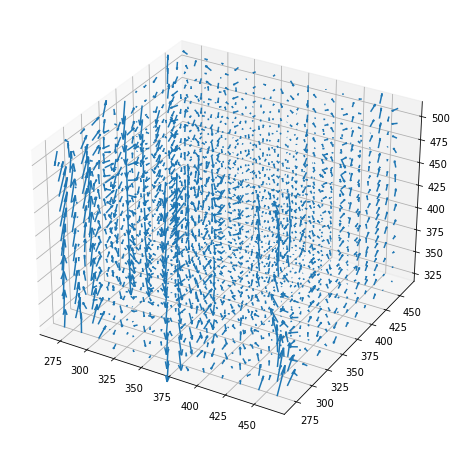

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
XX, YY, ZZ, TT = torch.meshgrid( (x_grid, x_grid, y_grid, t_grid) )
ax.quiver(XX[...,0].detach().numpy(), YY[...,0].detach().numpy(), ZZ[...,0].detach().numpy(),
          u[...,0].detach().numpy(), v[...,0].detach().numpy(), w[...,0].detach().numpy(), length=5)
plt.show()

# Convert tensors to NumPy arrays
XX_np = XX.detach().numpy()
YY_np = YY.detach().numpy()
ZZ_np = ZZ.detach().numpy()
TT_np = TT.detach().numpy()
u_np = u.detach().numpy()
v_np = v.detach().numpy()
w_np = w.detach().numpy()

# Save the arrays to a .npz file
np.savez('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/fluid_field_data_revised.npz', 
         XX=XX_np, YY=YY_np, ZZ=ZZ_np, TT=TT_np, u=u_np, v=v_np, w=w_np)

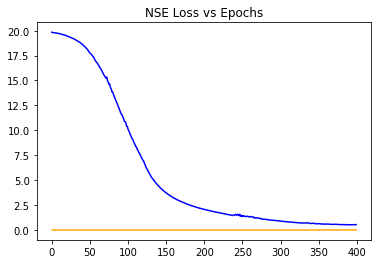

In [13]:
plt.plot(MSE_losses, color='blue')
plt.plot(NSE_losses, color='orange')
plt.title('NSE Loss vs Epochs')
plt.show()

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_14224/3390462300.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


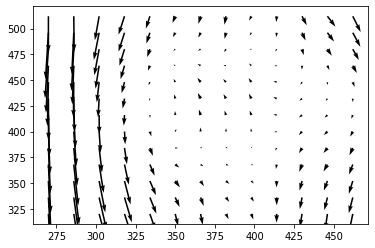

In [30]:
plt.close('all')

for frame in range(int(v.shape[-1])):
                plt.quiver(XX[:,6,:,frame].detach().numpy(), ZZ[:,6,:,frame].detach().numpy(), u[:,6,:,frame].detach().numpy(), w[:,6,:,frame].detach().numpy())
                plt.savefig(f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/output_images/reconstruction_revised{frame}.png', dpi=300)
                plt.close('all')
                
# Make gif
filenames = [f'/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/output_images/reconstruction_revised{i}.png' for i in range(len(t_grid))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/3DPINNs/Stokes Flow/restart/reconstruction_revised.gif', images, fps=5)

plt.quiver(XX[:,6,:,0].detach().numpy(), ZZ[:,6,:,0].detach().numpy(), u[:,6,:,0].detach().numpy(), w[:,6,:,0].detach().numpy())
plt.show()